In [39]:
import os
import random
import requests
import time
from PIL import Image
import base64
import io
import json
import re
from tqdm import tqdm
import numpy as np

In [40]:
import csv
import random
import time
import json
import copy


import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = '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'
os.environ['LANGSMITH_PROJECT'] = 'pr-wooden-hedgehog-65'
os.environ['OPENAI_API_KEY'] = 'sk-g4MycviIFf8Lad0v5zVKPljDpueIDBLuqIC1nsDAiRnLZVKg'
os.environ['OPENAI_API_BASE'] = 'https://api2.aigcbest.top/v1'

from typing import Any, List, Dict

# LangChain 和 LangSmith 的相关导入
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ChatMessage

def generate_from_openai_chat_completion_new(
    messages: List[Dict[str, str]],
    model: str,
    temperature: float,
    max_tokens: int,
    top_p: float,
    context_length: int, # 这个参数在ChatOpenAI中不直接使用，但为了保持签名一致而保留
    stop_token: str | None = None,
) -> str:
    """
    使用 LangChain 的 ChatOpenAI 生成聊天回复，并支持 LangSmith 追踪。
    函数签名与旧版完全兼容。
    """
    if "OPENAI_API_KEY" not in os.environ and "api_key" not in locals():
        raise ValueError("OPENAI_API_KEY environment variable must be set.")

    # 1. 初始化 LangChain 的 ChatOpenAI 客户端
    # 将旧函数的参数映射到 ChatOpenAI 的构造函数中
    llm = ChatOpenAI(
        # 从环境变量获取 key 和 base_url，提供默认值
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url=os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1"),
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        stop=[stop_token] if stop_token else None,
        model_kwargs={}, # 如果没有其他高级参数，可以为空字典或直接省略
        # 内置重试机制，替代旧的装饰器
        max_retries=3,
    )

    # 2. 将输入的字典列表转换为 LangChain 的消息对象
    # 这是一个必要的适配步骤
    langchain_messages = []
    for msg in messages:
        role = msg.get("role")
        content = msg.get("content", "")
        # 从字典中获取 name，如果不存在则为 None
        name = msg.get("name")

        if role == "user":
            langchain_messages.append(HumanMessage(content=content, name=name))
        elif role == "assistant":
            langchain_messages.append(AIMessage(content=content, name=name))
        elif role == "system":
            # 这会正确处理您提供的 few-shot 示例
            langchain_messages.append(SystemMessage(content=content, name=name))
        else:
            # 为其他可能的角色（如 'tool'）提供一个通用处理
            langchain_messages.append(ChatMessage(role=role, content=content))

    # 3. 调用 LLM 并获取结果
    response = llm.invoke(langchain_messages)

    # 4. 提取并返回内容，保持与旧函数相同的字符串输出
    return response.content

In [41]:
# example_messages_with_name = [{
#     'role': 'user',
#     'content': "hello"
# }]

# result = generate_from_openai_chat_completion_new(
#     messages=example_messages_with_name,
#     model="gpt-5.1",
#     temperature=0.7,
#     max_tokens=2000,
#     top_p=1.0,
#     context_length=4096,
#     stop_token=None
# )
# result

In [42]:
system_prompt = """You are an expert in evaluating GUI agent task trajectories. Your task is to assess the quality, effectiveness, and complexity of task trajectories for GUI manipulation tasks.

A trajectory consists of the following components:
1. High-level Instruction: Describes the user's overall intended task.
2. Interaction Sequence:
    - For all intermediate steps (Non-final turns):
        - Page Summary: A brief description of the webpage state.
        - Action: The specific operation executed (e.g., click, type).
        - Local Intent: The immediate purpose of that specific action.
    - For the final step (Last turn):
        - Full Accessibility Tree: The complete, simplified representation of the final webpage state.
        - Answer: The agent's final response (often in a Chain-of-Thought format) and the stop command indicating task completion.

When evaluating a trajectory, consider these key aspects:

### Evaluation Criteria:
1. Trajectory Coherence:
   - Do the low-level steps and corresponding actions follow a logical sequence toward the goal?
   - Are the actions clearly described and specific?
   - Are there redundant or unnecessary actions?

2. Task Completion:
   - Does the trajectory successfully achieve the instructed task?
   - Are all necessary interactions completed?
   - Are error cases handled appropriately?

3. Task Difficulty:
   - How many steps are required?
   - Does it involve cross-page navigation?
   - Is the instruction complex or abstract?
   - Did the agent have to perform error handling or self-correction?

### Scoring Guidelines:

#### 1. Trajectory Coherence (1-5)
- 5: The sequence is logically perfect and efficient. Every action clearly contributes to the goal with no redundancy.
- 4: The sequence is generally logical. There may be very minor inefficiencies or slightly unclear steps, but the overall flow is solid.
- 3: The sequence has some logical gaps or includes a few redundant actions (e.g., wandering briefly), but it eventually recovers or makes partial sense.
- 2: Significant inefficiencies or illogical detours. The agent wanders significantly before attempting the goal, or performs actions that contradict the intent.
- 1: The sequence is incoherent. It falls into an immediate deadlock, a repetitive loop, or actions are completely unrelated to the instruction.

#### 2. Task Completion (1-5)
- 5: The task is perfectly completed. All necessary interactions are done, and the final answer is correct and grounded in the evidence.
- 4: The task is mostly completed. The main goal is achieved, but there might be a minor detail missing in the final answer or a slight imperfection in the final state.
- 3: Partially completed. The agent performed some correct actions but failed to fully achieve the goal or the final answer is incorrect/incomplete.
- 2: Minimal progress. Only the initial setup or a few trivial actions were successful; the core task remains undone.
- 1: Complete failure. No meaningful progress was made toward the goal.

#### 3. Task Difficulty (1-5)
- 5 (Very Hard): Long horizon (>8 steps) requiring complex reasoning. Involves navigating multiple distinct pages, handling errors/popups, or synthesizing information from various sources.
- 4 (Hard): Moderate to long horizon (7-8 steps). Involves cross-page operations or a complex instruction that requires multi-step deduction.
- 3 (Medium): Moderate length (5-6 steps). Standard navigation and interaction tasks (e.g., searching and selecting an item) without significant obstacles.
- 2 (Easy): Short length (3-4 steps). Linear execution with minimal reasoning required (e.g., simple navigation).
- 1 (Very Easy): Trivial task (<3 steps). Completed on the same page or requires only a single direct action (e.g., "click the home button").

### Response Format:
You must output a JSON object with the following structure:
```json
{
  "reason": "<one line of simple reasoning process for the scores>",
  "score_coherence": <integer 1-5>,
  "score_completion": <integer 1-5>,
  "score_difficulty": <integer 1-5>
}"""

In [43]:
complete_file_dir = "/home/zjusst/qms/webarena/result_stage_3_generation/selected_router_trajs_with_intention_answer"
complete_file_names = os.listdir(complete_file_dir)
len(complete_file_names)

68

In [44]:
# 统计 random_selected_trajs 中每个traj_len的traj数量
traj_len_to_count = {}
for file_name in complete_file_names:
    with open(os.path.join(complete_file_dir, file_name), "r") as f:
        selected_dict = json.load(f)
    traj_len = len(selected_dict["selected_trajectory"])
    if traj_len not in traj_len_to_count:
        traj_len_to_count[traj_len] = 0
    traj_len_to_count[traj_len] += 1

# 打印 traj_len_to_count
for traj_len, count in traj_len_to_count.items():
    print(f"Traj Len {traj_len}: {count}")


Traj Len 4: 17
Traj Len 3: 17
Traj Len 2: 17
Traj Len 1: 17


In [45]:
def get_origin_traj_json(filepath, index):
    with open(os.path.join(filepath), "r") as f:
        origin_traj_json = json.load(f)
    return origin_traj_json[index]

#get_origin_traj_json("812_1.json", 0)

In [46]:
selected_dict

{'selected_trajectory': [["('/home/zjusst/qms/webarena/result_stage_2_intended_explore/add_local_intention_trajs/830.json', 6, 1, 'http://reddit.com/search?q=latest+advancements+in+website+development')",
   "click [21367] where [21367] is link 'Forums'",
   'The user wants to navigate to the main list of forums from a search results page.',
   "('/home/zjusst/qms/webarena/result_stage_2_intended_explore/add_local_intention_trajs/821.json', 9, 1, 'http://reddit.com/forums')"]],
 'Instruction': 'From the search results page, navigate to the main forums index and report the list of forums currently shown along with their subscriber status and number of submissions.',
 'Answer': "Let's think step-by-step. The trajectory shows that I started on a search results page and clicked the 'Forums' link in order to reach the main forums list. The final accessibility tree confirms that I am on a page titled 'List of forums', with a heading 'List of forums' and multiple forum entries shown as articl

In [47]:
def selected_trajectory_to_user_prompt(selected_dict):
    user_prompt = f"Instruction: {selected_dict['Instruction']}\n\n"

    selected_trajectory = selected_dict["selected_trajectory"]
    traj_len = len(selected_trajectory)
    for i in range(traj_len):
        filepath, index, is_after, _ = eval(selected_trajectory[i][0])
        orgin_json = get_origin_traj_json(filepath, index)

        page_description = orgin_json["web_desc_after"] if is_after else orgin_json["web_desc_before"]
        action = selected_trajectory[i][1]
        intention = selected_trajectory[i][2]
        user_prompt += f"""Page{i+1}:
Page Description: {page_description}
Action: {action}
Local Intent: {intention}
        
"""
    filepath, index, is_after, _ = eval(selected_trajectory[-1][3])
    orgin_json = get_origin_traj_json(filepath, index)
    final_a11y_tree = orgin_json["a11y_after"] if is_after else orgin_json["a11y_before"]
    user_prompt += f"""Page{traj_len+1}:
Final Page Accessibility Tree: {final_a11y_tree}

Final Answer: {selected_dict['Answer']}
    """

    user_prompt += f"""
Now, please generate your reason and score.
    """
    return user_prompt

with open("/home/zjusst/qms/webarena/result_stage_3_generation/selected_router_trajs_with_intention_answer/004_len2.json", "r") as f:
    selected_dict = json.load(f)
print(len(selected_dict["selected_trajectory"]))
print(selected_trajectory_to_user_prompt(selected_dict))

2
Instruction: Use the forum's search to look for information about 'explore search functionality' in the wiki section and open the relevant wiki page, or report what happens if the page does not exist.

Page1:
Page Description: The same forum post page with the comments section expanded, displaying individual comments, replies, and interactive elements for user engagement such as upvote/downvote buttons.
Action: type [7694] [explore search functionality ] where [7694] is searchbox 'Search query'
Local Intent: The user wants to find information or discussions related to 'explore search functionality'. This action leads to a search results page showing relevant posts and comments.
        
Page2:
Page Description: The page is a search results page displaying various posts and comments that match the keyword 'explore search functionality', with interactive elements like upvote and downvote buttons.
Action: click [8950] where [8950] is link 'Wiki'
Local Intent: The user attempted to navig

In [48]:
import csv

result_csv_path = "/home/zjusst/qms/webarena/result_stage_3_generation/rating_router.csv"
if not os.path.exists(result_csv_path):
    with open(result_csv_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["file_path", "reason", "score_coherence", "score_completion", "score_difficulty"])


In [49]:
def read_json_result(result):
    """
    解析类似```json
    {
    "reason": "The task trajectory includes a sequence of actions with a clear and logical progression towards the goal of accessing the edit history of a wiki page, making edits, and publishing them. Each action is well-documented with a specific local intent, contributing to a coherent sequence. The actions of navigating to the page history, entering the edit page, scrolling to view options, and saving changes are necessary steps to complete the task. The trajectory successfully implements the task by showing the final page with updated content, indicating proper task completion. As for task difficulty, the trajectory spans across a moderate number of steps and involves page navigation, editing, and saving changes, reflecting a medium level of complexity.",
    "score_coherence": 5,
    "score_completion": 5,
    "score_difficulty": 3
    }
    ```
    """

    if not result.startswith("```json"):
        # 直接解析
        try:
            return json.loads(result)
        except json.JSONDecodeError:
            raise ValueError(f"Invalid JSON format in result: {result}")
    else:
        # 从```json```中解析
        json_str = result.split("```json")[1]
        json_str = json_str[:-3]
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            raise ValueError(f"Invalid JSON format in result: {result}")

In [50]:
for file_name in tqdm(complete_file_names):
    with open(os.path.join(complete_file_dir, file_name), "r") as f:
        selected_dict = json.load(f)
    # len_i = len(selected_dict["selected_trajectory"])

    # if len_i_cnt_j[len_i] >= 17:
    #     continue
    # len_i_cnt_j[len_i] += 1

    example_messages_with_name = [
        {
            'role': 'system',
            'content': system_prompt
        },
        {
            'role': 'user',
            'name': 'user',
            'content': selected_trajectory_to_user_prompt(selected_dict)
        }
    ]

    result = generate_from_openai_chat_completion_new(
        messages=example_messages_with_name,
        model="gpt-5.1",
        temperature=0.7,
        max_tokens=2000,
        top_p=1.0,
        context_length=8192,
        stop_token=None
    )
    
    result_json = read_json_result(result)

    with open(result_csv_path, "a") as f:
        writer = csv.writer(f)
        writer.writerow([os.path.join(complete_file_dir, file_name), result_json["reason"], result_json["score_coherence"], result_json["score_completion"], result_json["score_difficulty"]])

100%|██████████| 68/68 [04:30<00:00,  3.98s/it]


In [51]:
import csv
import json

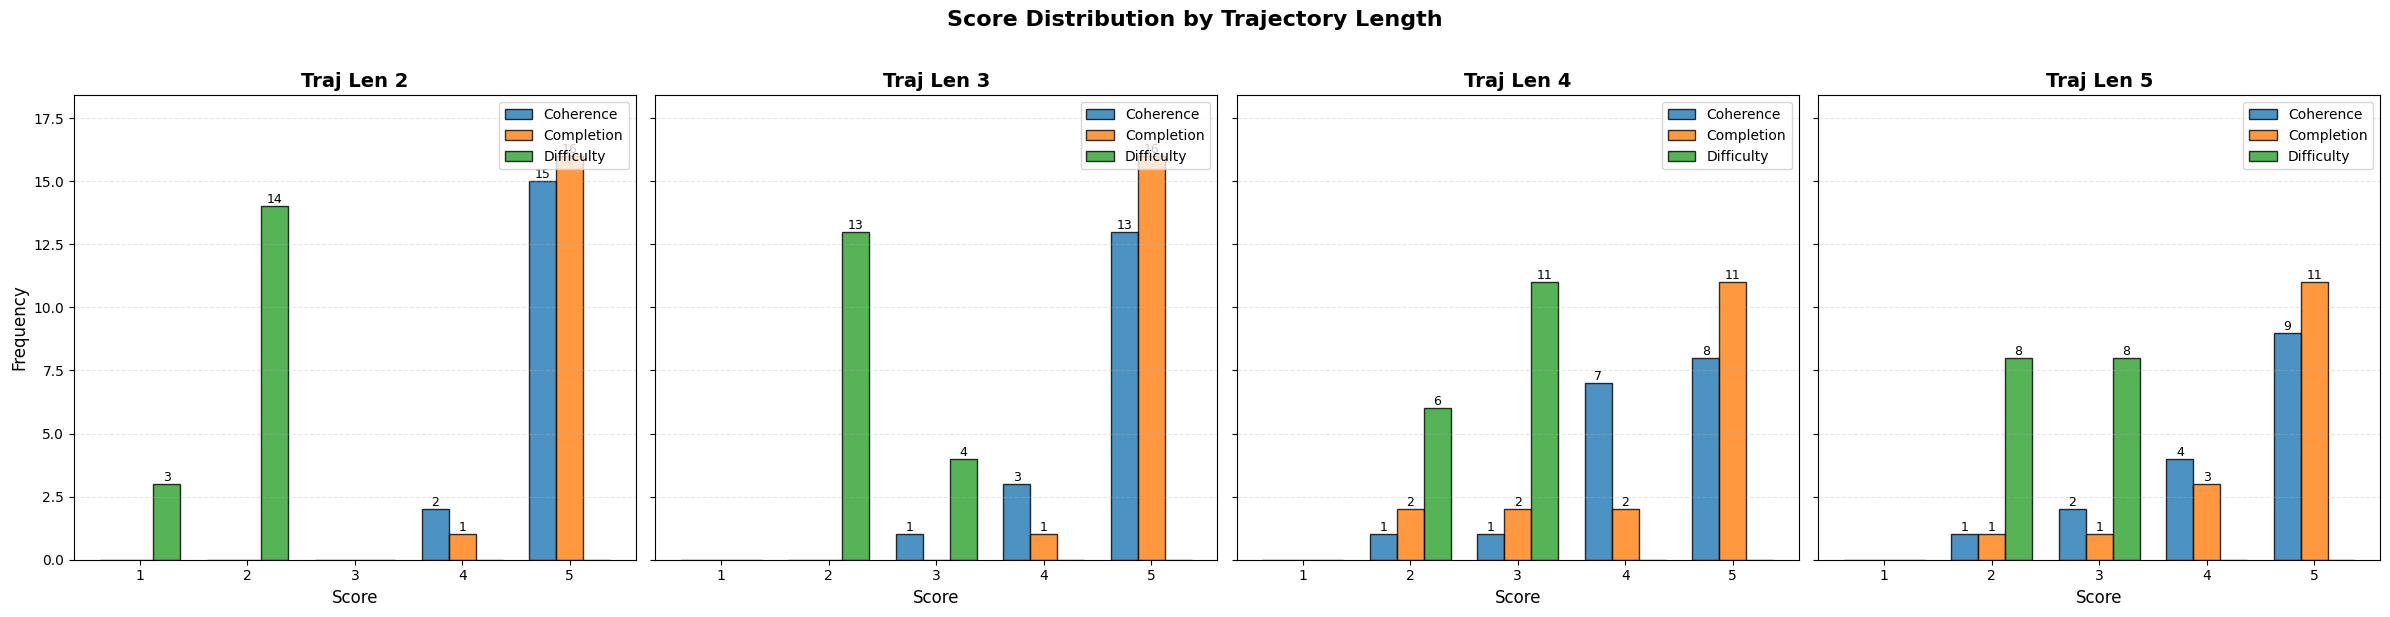

In [52]:
# 方案1：每个长度一个子图，每个子图显示三种评分的分布（分组柱状图）
import matplotlib.pyplot as plt
import numpy as np

# 读取数据并组织
rating_csv_path = "/home/zjusst/qms/webarena/result_stage_3_generation/rating_router.csv"
with open(rating_csv_path, "r") as f:
    reader = csv.reader(f)
    next(reader)  # 跳过表头
    rating_data = [row for row in reader]

# 组织数据：traj_len -> {score_type -> [scores]}
traj_len_to_scores = {}
for row in rating_data:
    file_path = row[0]
    with open(file_path, "r") as f:
        selected_dict = json.load(f)
    traj_len = len(selected_dict["selected_trajectory"]) + 1
    if traj_len not in traj_len_to_scores:
        traj_len_to_scores[traj_len] = {
            'score_coherence': [],
            'score_completion': [],
            'score_difficulty': []
        }
    traj_len_to_scores[traj_len]['score_coherence'].append(int(row[2]))
    traj_len_to_scores[traj_len]['score_completion'].append(int(row[3]))
    traj_len_to_scores[traj_len]['score_difficulty'].append(int(row[4]))

# 绘图
fig, axs = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
traj_lens = [2, 3, 4, 5]
score_types = ['score_coherence', 'score_completion', 'score_difficulty']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色、橙色、绿色
labels = ['Coherence', 'Completion', 'Difficulty']

x = np.arange(1, 6)  # 评分1-5
width = 0.25  # 柱状图宽度

for idx, traj_len in enumerate(traj_lens):
    if traj_len not in traj_len_to_scores:
        continue
    
    # 统计每种评分的分布
    for i, score_type in enumerate(score_types):
        scores = traj_len_to_scores[traj_len][score_type]
        counts = [scores.count(s) for s in range(1, 6)]
        offset = (i - 1) * width  # 居中排列
        bars = axs[idx].bar(x + offset, counts, width, label=labels[i], 
                           color=colors[i], edgecolor='black', alpha=0.8)
        
        # 在柱子上标上数量
        for bar, count in zip(bars, counts):
            if count > 0:
                axs[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                             str(count), ha='center', va='bottom', fontsize=9)
    
    axs[idx].set_title(f'Traj Len {traj_len}', fontsize=14, fontweight='bold')
    axs[idx].set_xlabel('Score', fontsize=12)
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(['1', '2', '3', '4', '5'])
    axs[idx].set_ylim(0, max([max([traj_len_to_scores[tl][st].count(s) 
                                   for s in range(1, 6)]) 
                             for tl in traj_lens if tl in traj_len_to_scores 
                             for st in score_types]) * 1.15)
    if idx == 0:
        axs[idx].set_ylabel('Frequency', fontsize=12)
    axs[idx].legend(loc='upper right', fontsize=10)
    axs[idx].grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Score Distribution by Trajectory Length', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [53]:
# 分长度统计三种分数的均分，并打印

for traj_len in [2, 3, 4, 5]:
    scores = traj_len_to_scores[traj_len]
    print(f"Traj Len {traj_len}:")
    for score_type in score_types:
        print(f"{score_type}: {np.mean(scores[score_type])}")
    print("\n")

Traj Len 2:
score_coherence: 4.882352941176471
score_completion: 4.9411764705882355
score_difficulty: 1.8235294117647058


Traj Len 3:
score_coherence: 4.705882352941177
score_completion: 4.9411764705882355
score_difficulty: 2.235294117647059


Traj Len 4:
score_coherence: 4.294117647058823
score_completion: 4.294117647058823
score_difficulty: 2.6470588235294117


Traj Len 5:
score_coherence: 4.3125
score_completion: 4.5
score_difficulty: 2.5




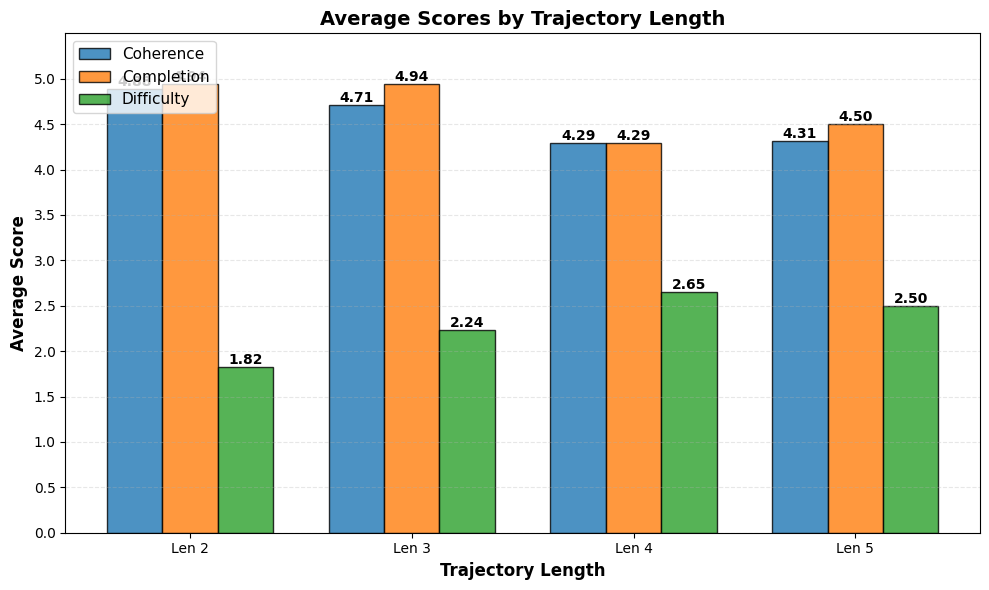

In [54]:
# 方案1：分组柱状图 - 最直观地对比每个长度下三种评分的均分
import matplotlib.pyplot as plt
import numpy as np

# 读取数据并组织
# rating_csv_path = "/home/zjusst/qms/webarena/result_stage_3_generation/rating_random_v3_gpt5__1.csv"
with open(rating_csv_path, "r") as f:
    reader = csv.reader(f)
    next(reader)  # 跳过表头
    rating_data = [row for row in reader]

# 组织数据：traj_len -> {score_type -> [scores]}
traj_len_to_scores = {}
for row in rating_data:
    file_path = row[0]
    with open(file_path, "r") as f:
        selected_dict = json.load(f)
    traj_len = len(selected_dict["selected_trajectory"]) + 1
    if traj_len not in traj_len_to_scores:
        traj_len_to_scores[traj_len] = {
            'score_coherence': [],
            'score_completion': [],
            'score_difficulty': []
        }
    traj_len_to_scores[traj_len]['score_coherence'].append(int(row[2]))
    traj_len_to_scores[traj_len]['score_completion'].append(int(row[3]))
    traj_len_to_scores[traj_len]['score_difficulty'].append(int(row[4]))

# 计算每个长度下三种评分的平均值
traj_lens = [2, 3, 4, 5]
score_types = ['score_coherence', 'score_completion', 'score_difficulty']
labels = ['Coherence', 'Completion', 'Difficulty']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色、橙色、绿色

# 准备数据
means_data = {label: [] for label in labels}
for traj_len in traj_lens:
    for i, score_type in enumerate(score_types):
        if traj_len in traj_len_to_scores:
            scores = traj_len_to_scores[traj_len][score_type]
            mean_score = np.mean(scores) if scores else 0
            means_data[labels[i]].append(mean_score)
        else:
            means_data[labels[i]].append(0)

# 绘图
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(traj_lens))  # 长度位置
width = 0.25  # 柱状图宽度

for i, (label, color) in enumerate(zip(labels, colors)):
    offset = (i - 1) * width  # 居中排列
    bars = ax.bar(x + offset, means_data[label], width, 
                  label=label, color=color, edgecolor='black', alpha=0.8)
    
    # 在柱子上标上数值（保留2位小数）
    for bar, value in zip(bars, means_data[label]):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                   f'{value:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Trajectory Length', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax.set_title('Average Scores by Trajectory Length', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Len {tl}' for tl in traj_lens])
ax.set_ylim(0, 5.5)
ax.set_yticks(np.arange(0, 5.5, 0.5))
ax.legend(loc='upper left', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()